In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

In [3]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

In [4]:
import time
import os
import warnings
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from functools import partial, partialmethod
from kde_ebm.mixture_model import fit_all_gmm_models, fit_all_kde_models
from kde_ebm import plotting
from sSuStaIn.sEBMSustain import sEBMSustain
import numpy.ma as ma
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

data_save_path = "/nethome/rtandon32/ebm/real_datasets/ehbs"

def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

def readData():
	peptide_fname = os.path.join(data_save_path, "Peptide Area Report_BSR2020-102_80pep.csv")
	skyline_fname = os.path.join(data_save_path, "SkylineRatios-FullPercesion_2021_0608.csv")
	skyline_df = pd.read_csv(skyline_fname, index_col=0)
	peptide_df = pd.read_csv(peptide_fname)
	# Get the labels for all subjects in the data
	label_df = readLabels(peptide_df)
	# Impute missing values
	Ximp = imputeData(skyline_df)
	ss = StandardScaler()
	scaledX = ss.fit_transform(Ximp)
	scaledX = pd.DataFrame(scaledX, index=Ximp.index, columns=Ximp.columns)
	scaledX = scaledX.reindex(label_df["sbj"])
	Ximp = Ximp.reindex(label_df["sbj"])
	return scaledX, Ximp, label_df

def readLabels(peptide_df):
	label_df = peptide_df[["Replicate", "Condition"]]
	label_df = label_df[label_df["Condition"].isin(["AD", "Control", "AsymAD"])]
	label_dict = dict(zip(label_df["Replicate"], label_df["Condition"]))
	label_df = pd.DataFrame.from_dict(label_dict, orient="index").reset_index()
	label_df.columns = ["sbj", "DX"]
	return label_df

def imputeData(x):
	x_imp = x.T.values.copy()
	n_neighbors=10
	x_imp = imptKNN(x_imp, n_neighbors)
	Ximp = pd.DataFrame(x_imp, index=x.columns, columns=x.index)
	return Ximp

def imptKNN(x, n_neighbors, weights="uniform"):
	imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
	x_imputed = imputer.fit_transform(x)
	return x_imputed

def extract_classes(X, label_df, dx):
	merged = pd.merge(X, label_df, left_index=True, right_index=True)
	merged_subset = merged[merged["DX"].isin(dx)]
	# y = merged_subset["DX"].map({"Control":0, "AD":1}).to_numpy()
	y = merged_subset["DX"]
	x = merged_subset[merged_subset.columns.difference(["DX"])]
	x = x.to_numpy().astype(float)
	return x, y

scaledX, Ximp, label_df = readData()
label_df.set_index("sbj", inplace=True)

X, y = extract_classes(Ximp, label_df, ["Control", "AD"])
print("outputs from extract classes \n", X.shape, y.shape)
y = y.map({"Control":0, "AD":1}).to_numpy()
bm_names = Ximp.columns.tolist()

outputs from extract classes 
 (262, 75) (262,)


## Change the path to the pickled file


In [5]:
def _dictionarize_sequence(S, stage_size):
    # stage_size = self.stage_size
    stages_cumsum = np.cumsum(stage_size, dtype=int)
    S_dict = {}

    for _ in range(len(stage_size)-1,0,-1):
        idx = (stages_cumsum[_-1], stages_cumsum[_])
        stage = S[idx[0]: idx[1]]
        S_dict[_] = stage
    S_dict[0] = S[0:idx[0]]
    S_dict_ = {i:S_dict[i] for i in range(len(stage_size))}
    return S_dict_

In [6]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_ehbs1_gmm/pickle_files/sim_ehbs1_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [7]:
seq = pkl["samples_sequence"][:,:,0]
pep_names = [[bm_names[_] for _ in seq[seq_id].astype(int)] for seq_id in range(4)]

In [8]:
path_pep_links = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_ehbs1_gmm/peptide_protein_links.csv"
pep_df = pd.read_csv(path_pep_links)

In [10]:
shape_seq = pkl["shape_seq"]
mod_dict = dict(zip(pep_df["peptide"], pep_df["module"]))

In [15]:
seq_df = pd.DataFrame(pep_names).T
d0 = _dictionarize_sequence(seq_df[0].map(mod_dict), shape_seq[0])
d1 = _dictionarize_sequence(seq_df[1].map(mod_dict), shape_seq[1])
d2 = _dictionarize_sequence(seq_df[2].map(mod_dict), shape_seq[2])
d3 = _dictionarize_sequence(seq_df[3].map(mod_dict), shape_seq[3])

In [35]:
d = d3
Counter(d[0]), Counter(d[1]), Counter(d[2]), Counter(d[3]), Counter(d[4])

(Counter({'M1': 4, nan: 3, 'grey': 2, 'M1/M6': 2, 'M4': 1}),
 Counter({'grey': 10, 'M4': 9, 'M2': 6, nan: 3, 'M6': 2, 'M1': 1}),
 Counter({nan: 7, 'M8': 3, 'M1': 1}),
 Counter({'M8': 4, nan: 1, 'M2': 1, 'M4': 1, 'M5': 1, 'M13': 1}),
 Counter({'grey': 4, 'M1': 4, 'M4': 2, 'M8': 2}))

## Histogram plots

In [38]:
mixture_type = "gmm"
if mixture_type=="kde":
    mm_fit = fit_all_kde_models
elif mixture_type == "gmm":
    mm_fit = fit_all_gmm_models

mixtures = mm_fit(X, y)

L_yes                   = np.zeros(X.shape)
L_no                    = np.zeros(X.shape)

for i in range(X.shape[1]):
    if mixture_type == "gmm":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(None, X[:, i])
    elif mixture_type == "kde":
        L_no[:, i], L_yes[:, i] = mixtures[i].pdf(X[:, i].reshape(-1, 1))
        
L_no = process_L(L_no)
L_yes = process_L(L_yes)

In [49]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [15]*5
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 6
p_absorb = 0.3
SuStaInLabels = bm_names
dataset_name            = 'sim_ehbs1'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, output_folder, dataset_name, use_parallel_startpoints)

In [50]:
## Get the prob mat for the AsymAD subjects

In [51]:
# Get the prob mat for the mci subjects
X_asym, y_asym = extract_classes(Ximp, label_df, ["AsymAD"])
prob_mat_asym = mixture_model.get_prob_mat(X_asym, mixtures)

In [52]:
L_no_asym = prob_mat_asym[:,:,0]
L_yes_asym = prob_mat_asym[:,:,1]
L_no_asym = process_L(L_no_asym)
L_yes_asym = process_L(L_yes_asym)

## Subtype and Stage the subjects

In [53]:
pkl["samples_sequence"].shape

(4, 75, 1000000)

In [54]:
n_stages

5

In [55]:
# Subtype and Stage the MCI subjects
last_N = 400000
N_samples = 1000
sustainData_asym = sEBMSustainData(L_yes_asym, L_no_asym, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_asym, \
prob_ml_subtype_asym, \
ml_stage_asym, \
prob_ml_stage_asym, \
prob_subtype_asym, \
prob_stage_asym, \
prob_subtype_stage_asym = sustain.subtype_and_stage_individuals(sustainData_asym, shape_seq, samples_sequence, samples_f, N_samples)


In [56]:
unique, counts = np.unique(ml_stage_asym, return_counts=True)
dict(zip(unique, counts))

{1.0: 19, 2.0: 41, 3.0: 21, 4.0: 48, 5.0: 1}

### Subtype and Stage CN/AD data

In [57]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence, samples_f, N_samples)


### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [59]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
# cnad_solved[["PTID", "EXAMDATE"]] = df_cnad[["PTID", "EXAMDATE"]]

In [63]:
# DataFrame for MCI subjects
array_subtype_stage_asym = np.hstack([ml_subtype_asym, ml_stage_asym])
mci_solved = pd.DataFrame(data=array_subtype_stage_asym, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
# mci_solved[["PTID", "EXAMDATE"]] = df_mci[["PTID", "EXAMDATE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [65]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"AsymAD"})

In [118]:
subtype_select = 3.0
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","AsymAD"]).reset_index()

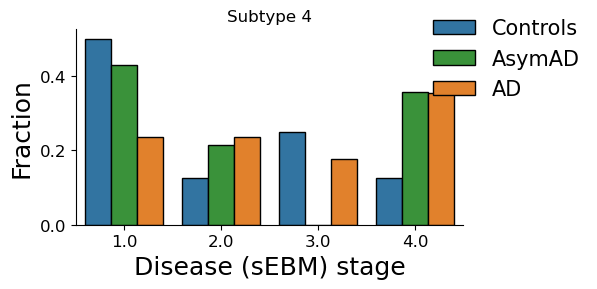

In [119]:
fig, ax = plt.subplots(figsize=(6,3))
hue_order=["Controls", "AsymAD", "AD"]
palette = ["C0", "C2","C1"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("Disease (sEBM) stage", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title="", fontsize=15, framealpha=0.0, loc=(0.9,0.6))
ax.set_title("Subtype {}".format(int(ix[int(subtype_select)] + 1), fontsize=18))
# ax.set_title("Subtype {}".format(int(ix[int(subtype_select)]), fontsize=18))
# ax.text(s=r"p-value ($\chi^{2}$) < 1 x $10^{-18}$ ",x=1.0,y=0.5, fontsize=15)
sns.despine()
plt.tight_layout()
figname = "Subtype{}.png".format(ix[int(subtype_select)]+1)
fig.savefig("/nethome/rtandon32/ebm/s-SuStain-outputs/sim_ehbs1_gmm/figures/{}".format(figname), dpi=300, transparent=True)

In [69]:
ix

array([2, 0, 1, 3])

In [70]:
pkl["samples_f"].mean(axis=1)

array([0.36415305, 0.11183305, 0.42673941, 0.09727448])

In [122]:
final_df[final_df["subtype"]==2.0].pivot_table(index="stage", columns="DX",aggfunc=len, fill_value=0)

subtype                
DX         AD AsymAD Controls
stage                        
2.0         0      0        4
3.0         1     14        3
4.0        15     35        6

In [102]:
temp_mean_f

array([0.36281206, 0.11220025, 0.4263842 , 0.0986035 ])

In [103]:
ix

array([2, 0, 1, 3])